In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d lygitdata/garmentiq-classification-set-nordstrom-and-myntra

Dataset URL: https://www.kaggle.com/datasets/lygitdata/garmentiq-classification-set-nordstrom-and-myntra
License(s): CC-BY-NC-SA-4.0
 98% 1.33G/1.36G [00:14<00:00, 147MB/s]
100% 1.36G/1.36G [00:15<00:00, 96.9MB/s]


In [4]:
import zipfile

# Path to your dataset zip file
zip_path = "/content/garmentiq-classification-set-nordstrom-and-myntra.zip"
extract_path = "/content"

# Unzipping the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully!")

Dataset extracted successfully!


In [5]:
#Importing Libraries
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers

In [6]:
#Loading the CSV and mapping images to labels
df = pd.read_csv('/content/metadata.csv')  # CSV with filename and label
df['filepath'] = df['filename'].apply(lambda x: os.path.join('/content/images', x))

In [7]:
#Generating train and test dataset
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['garment'], random_state=42)
print(f"Training dataset size: {train_df.shape}")
print(f"Testing dataset size: {test_df.shape}")

Training dataset size: (18612, 5)
Testing dataset size: (4654, 5)


In [8]:
#Organizing images into subfolders of garment types
import shutil

def copy_images(df, split):
    for _, row in df.iterrows():
        label_folder = os.path.join('data', split, row['garment'])
        os.makedirs(label_folder, exist_ok=True)
        shutil.copy(row['filepath'], os.path.join(label_folder, row['filename']))

copy_images(train_df, 'train')
copy_images(test_df, 'test')

In [9]:
#Visualizing the hierarchy
def print_directory_structure(root_dir, max_files_per_folder=5):
    for dirpath, dirnames, filenames in os.walk(root_dir):
        level = dirpath.replace(root_dir, '').count(os.sep)
        indent = '│   ' * level + '├── '
        print(f'{indent}{os.path.basename(dirpath)}/')

        # Print only a few files (up to max_files_per_folder)
        for f in filenames[:max_files_per_folder]:
            print(f'{indent}    {f}')

print_directory_structure('data', max_files_per_folder=3)  # Adjust max_files_per_folder as needed

├── data/
│   ├── test/
│   │   ├── shorts/
│   │   ├──     shorts_3018.jpg
│   │   ├──     shorts_23.jpg
│   │   ├──     shorts_1647.jpg
│   │   ├── short sleeve top/
│   │   ├──     short_sleeve_top_763.jpg
│   │   ├──     short_sleeve_top_3257.jpg
│   │   ├──     short_sleeve_top_949.jpg
│   │   ├── long sleeve dress/
│   │   ├──     long_sleeve_dress_1184.jpg
│   │   ├──     long_sleeve_dress_1698.jpg
│   │   ├──     long_sleeve_dress_154.jpg
│   │   ├── long sleeve top/
│   │   ├──     long_sleeve_top_562.jpg
│   │   ├──     long_sleeve_top_1431.jpg
│   │   ├──     long_sleeve_top_1249.jpg
│   │   ├── vest dress/
│   │   ├──     vest_dress_3037.jpg
│   │   ├──     vest_dress_192.jpg
│   │   ├──     vest_dress_2568.jpg
│   │   ├── skirt/
│   │   ├──     skirt_121.jpg
│   │   ├──     skirt_215.jpg
│   │   ├──     skirt_463.jpg
│   │   ├── short sleeve dress/
│   │   ├──     short_sleeve_dress_919.jpg
│   │   ├──     short_sleeve_dress_456.jpg
│   │   ├──     short_sleeve_dress_432.j

In [10]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

**Loading VGG16 Model**

In [11]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.summary()  # Check model architecture

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

**Fine Tuning Convolutional Layers**

In [18]:
for layer in base_model.layers:
    if layer.name in ["block5_conv1", "block5_conv2", "block5_conv3", "block4_conv2", "block4_conv3"]:
        layer.trainable = True
    else:
        layer.trainable = False  # Keep other layers frozen

**Model Architecture**

In [19]:
model = Sequential([
    base_model,
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(9, activation='softmax')
])

In [22]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,320,969 (62.26 MB)

 Trainable params: 13,405,321 (51.14 MB)

 Non-trainable params: 2,915,648 (11.12 MB)

In [20]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

**Data Augmentation**

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale = 1./255, # Normalize the pixel values to range [0,1]
    rotation_range = 15, # Random rotations between -15° to +15°
    width_shift_range=0.1,  # Random horizontal shifts (10% of image width)
    height_shift_range=0.1,  # Random vertical shifts (10% of image height)
    shear_range=0.1,  # Random shear transformations
    zoom_range=0.1,  # Random zoom (up to 10%)
    horizontal_flip=True,  # Random horizontal flip
    fill_mode='nearest'  # Fill empty pixels after transformations
)

train_gen = train_datagen.flow_from_directory('data/train', target_size=(224,224), class_mode='categorical')

test_datagen = ImageDataGenerator(rescale = 1./255)
test_gen = test_datagen.flow_from_directory('data/test', target_size=(224,224), class_mode='categorical')

Found 18612 images belonging to 9 classes.
Found 4654 images belonging to 9 classes.


In [23]:
history = model.fit(
    train_gen,
    epochs=10,
    validation_data=test_gen
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 340s 564ms/step - accuracy: 0.7210 - loss: 0.9145 - val_accuracy: 0.9340 - val_loss: 0.3056
Epoch 2/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 321s 551ms/step - accuracy: 0.9134 - loss: 0.3698 - val_accuracy: 0.9489 - val_loss: 0.2523
Epoch 3/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 321s 550ms/step - accuracy: 0.9319 - loss: 0.3019 - val_accuracy: 0.9497 - val_loss: 0.2364
Epoch 4/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 338s 580ms/step - accuracy: 0.9422 - loss: 0.2522 - val_accuracy: 0.9474 - val_loss: 0.2224
Epoch 5/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 319s 548ms/step - accuracy: 0.9492 - loss: 0.2184 - val_accuracy: 0.9510 - val_loss: 0.2214
Epoch 6/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 318s 547ms/step - accuracy: 0.9500 - loss: 0.2122 - val_accuracy: 0.9534 - val_loss: 0.2149
Epoch 7/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 338s 581ms/step - accuracy: 0.9553 - loss: 0.1857 - val_accuracy: 0.9594 - val_loss: 0.2011
Epoch 8/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 321s 552ms/step - accuracy: 0.9643 -

In [24]:
model.save('my_cnn_model.h5')  # HDF5 format

In [25]:
model.save('my_model.keras')

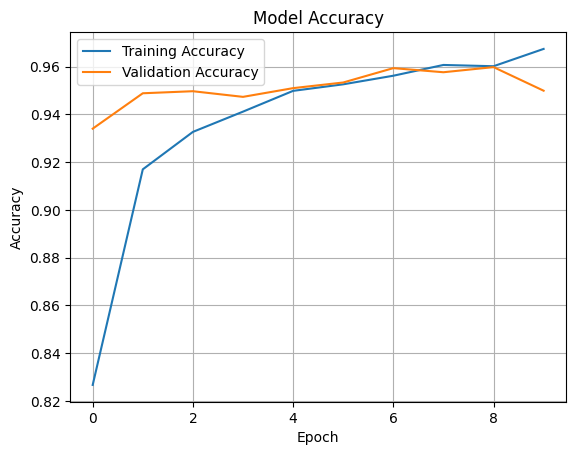

In [26]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.grid(True)
plt.show()

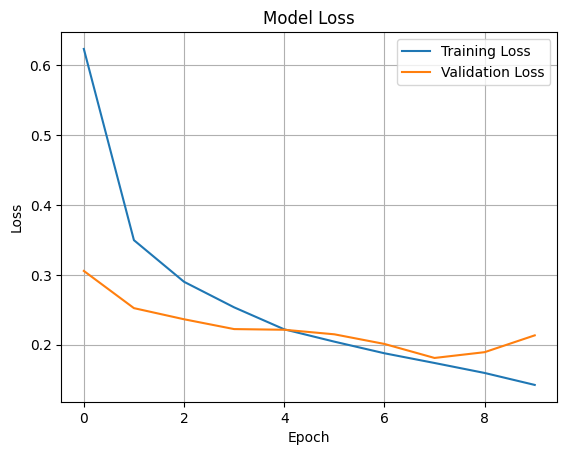

In [27]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.grid(True)
plt.show()

In [29]:
test_loss, test_acc = model.evaluate(test_gen)
print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test Loss: {test_loss:.4f}')

146/146 ━━━━━━━━━━━━━━━━━━━━ 23s 154ms/step - accuracy: 0.9529 - loss: 0.2008
Test Accuracy: 0.9499
Test Loss: 0.2134


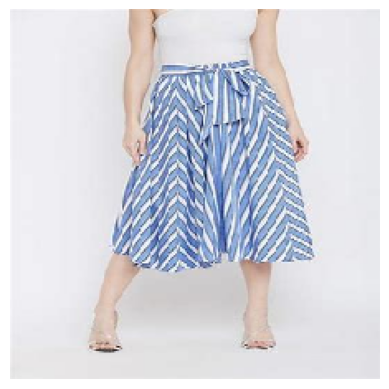

In [31]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

img_path = '/content/download (1).jpg'
img = image.load_img(img_path, target_size=(224, 224))

plt.imshow(img)
plt.axis('off')  # Hide axes for a cleaner look
plt.show()

In [30]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess image
img_path = '/content/download (1).jpg'
img = image.load_img(img_path, target_size=(224, 224))  # Match model input size
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Shape becomes (1, 224, 224, 3)
img_array /= 255.  # Scale if you used rescale in generator

# Predict
pred = model.predict(img_array)
pred_class = np.argmax(pred, axis=1)

# If you want the actual class name
class_indices = train_gen.class_indices
class_labels = dict((v,k) for k,v in class_indices.items())
print(f"Predicted class: {class_labels[pred_class[0]]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: skirt
